## This notebook will implement DDIM, alternative sampling method for Stable Diffusion

### Note: The majority of code in this notebook are similar to [DDPM](./DDPM.ipynb). The only different is on sampling method.

In [1]:
import random
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

no_train = False
fashion = True
batch_size = 256
n_epochs = 20
lr = 0.0001
store_path = "ddpm_fashion.pt" if fashion else "ddpm_mnist.pt"

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()
    
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)
    ]
)
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [3]:
class DDPM(nn.Module):
  def __init__(self, network, n_steps=200, min_b=10**-4, max_b= 0.02,device=None, image_chw=(1,28,28)):
    super().__init__()
    self.n_steps = n_steps
    self.device = device
    self.image_chw = image_chw
    self.network = network.to(device)
    self.beta = torch.linspace(min_b,max_b,n_steps).to(device)
    self.alpha= 1 - self.beta
    self.alpha_bar=torch.tensor([torch.prod(self.alpha[:i+1]) for i in range(len(self.alpha))]).to(device)

  def forward(self,x0,t,eta=None): # forward process on DDPM
    n,c,h,w = x0.shape
    a_bar = self.alpha_bar[t]
    if eta is None:
      eta = torch.randn(n,c,h,w).to(self.device)

    noise = a_bar.sqrt().reshape(n,1,1,1)*x0 + (1-a_bar).sqrt().reshape(n,1,1,1)*eta
    return noise

  def backward(self,x,t): # reverse process on DDPM
    return self.network(x,t)


### UNET

In [4]:
class Block(nn.Module):
  def __init__(self,shape, in_c, out_c, kernel_size=3, stride=1,padding=1, activation=None, normalize= True):
    super().__init__()
    self.ln= nn.LayerNorm(shape)
    self.conv1 = nn.Conv2d(in_c,out_c,kernel_size,stride,padding)
    self.conv2 = nn.Conv2d(out_c,out_c,kernel_size,stride,padding)
    self.activation = nn.SiLU() if activation is None else activation
    self.normalize = normalize

  def forward(self,x):
    out = self.ln(x) if self.normalize else x
    out = self.activation(self.conv1(out))
    out = self.activation(self.conv2(out))
    return out

In [5]:
class UNet(nn.Module):
  def __init__(self, n_steps=1000, time_emb_dim=100):
    super().__init__()
    self.time_embed = nn.Embedding(n_steps, time_emb_dim)
    self.time_embed.weight.data = self.sinusoidal_embedding(n_steps,time_emb_dim)
    self.time_embed.requires_grad_(False)

    # Left U
    self.te1 = self._make_te(time_emb_dim, 1)
    self.b1 = nn.Sequential(
        Block((1, 28, 28), 1, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10)
    )
    self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

    self.te2 = self._make_te(time_emb_dim, 10)
    self.b2 = nn.Sequential(
        Block((10, 14, 14), 10, 20),
        Block((20, 14, 14), 20, 20),
        Block((20, 14, 14), 20, 20)
    )
    self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
    self.te3 = self._make_te(time_emb_dim, 20)
    self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
    self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

    # Middle U

    self.te_mid = self._make_te(time_emb_dim, 40)
    self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

    # Second half
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(40, 40, 4, 2, 1),
        nn.SiLU(),
        nn.ConvTranspose2d(40, 40, 2, 1)
    )

    self.te4 = self._make_te(time_emb_dim, 80)
    self.b4 = nn.Sequential(
        Block((80, 7, 7), 80, 40),
        Block((40, 7, 7), 40, 20),
        Block((20, 7, 7), 20, 20)
    )

    self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
    self.te5 = self._make_te(time_emb_dim, 40)
    self.b5 = nn.Sequential(
        Block((40, 14, 14), 40, 20),
        Block((20, 14, 14), 20, 10),
        Block((10, 14, 14), 10, 10)
    )

    self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
    self.te_out = self._make_te(time_emb_dim, 20)
    self.b_out = nn.Sequential(
        Block((20, 28, 28), 20, 10),
        Block((10, 28, 28), 10, 10),
        Block((10, 28, 28), 10, 10, normalize=False)
    )

    self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

  def forward(self, x, t):
    t = self.time_embed(t)
    n = len(x)
    out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))
    out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))
    out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

    out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

    out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
    out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

    out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
    out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

    out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
    out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

    out = self.conv_out(out)

    return out

  @staticmethod
  def sinusoidal_embedding(n,d):

    embedding = torch.zeros(n,d)
    wk = torch.tensor([1/10000 ** (2*j/d) for j in range(d)])
    wk = wk.reshape((1,d))

    t = torch.arange(n).reshape((n,1))
    embedding[:,::2]  = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

  def _make_te(self, dim_in, dim_out):
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out)
    )

## DDIM 
This is DDIM Sampling method.

Instead of sampling for $x_t$ for every $t$, **DDIM** only sample a subsample of $t$, such as: $t_0,t_3,t_6,t_9,..$. This helps reduce the computing speed in sampling method, help speed up the generating process significantly.

The formular for DDIM sampling:

$$
 x_{\tau_{i-1}} = \sqrt{\alpha_{\tau_{i-1}}}\Bigg(
            \frac{x_{\tau_i} - \sqrt{1 - \alpha_{\tau_i}}\epsilon_\theta(x_{\tau_i})}{\sqrt{\alpha_{\tau_i}}}
            \Bigg) \
            + \sqrt{1 - \alpha_{\tau_{i- 1}} - \sigma_{\tau_i}^2} \cdot \epsilon_\theta(x_{\tau_i}) \
            + \sigma_{\tau_i} \epsilon_{\tau_i}
$$

where $\epsilon_{\tau_i}$ is random noise,
    $\tau$ is a subsequence of $[1,2,\dots,T]$ of length $S$, and:
$$\sigma_{\tau_i} =
    \eta \sqrt{\frac{1 - \alpha_{\tau_{i-1}}}{1 - \alpha_{\tau_i}}}
    \sqrt{1 - \frac{\alpha_{\tau_i}}{\alpha_{\tau_{i-1}}}}$$

If $\eta =1$, then the above sampling process becomes a DDPM sampling process.


In [28]:
def sampling(ddpm, n_sample=16,device=None, c=1, h=28, w=28, jump = 10, ddim_eta = 1.):

  with torch.no_grad():
    if device is None:
      device = ddpm.device
    x = torch.randn(n_sample,c,h,w).to(device)

    steps = ddpm.n_steps
    alpha_bar = ddpm.alpha_bar
    time_steps = np.arange(0,steps,jump) + 1
    ddim_alpha = alpha_bar[time_steps].clone()
    ddim_alpha_prev = torch.cat([alpha_bar[0:1], alpha_bar[time_steps[:-1]]])
    ddim_sigma = (ddim_eta *
                               ((1 - ddim_alpha_prev) / (1 - ddim_alpha) *
                                (1 - ddim_alpha / ddim_alpha_prev)) ** .5)
    
    
    
    for i, step in enumerate(np.flip(time_steps)):
      index = len(time_steps)-i-1
      
      ts = (torch.ones(n_sample,1)*step).to(device).long()

      e_t = ddpm.backward(x,ts)
      
      alpha = ddim_alpha[index]
      alpha_prev = ddim_alpha_prev[index]
      
      sigma = ddim_sigma[index]
      
      pred_x0 = (x - (1 - alpha).sqrt() * e_t)/alpha.sqrt()
      
      dir_xt = (1. - alpha_prev-sigma**2).sqrt() * e_t
      
      noise = torch.randn_like(x)
      
      x = alpha_prev.sqrt() * pred_x0 + dir_xt + sigma * noise
  return x


### Training

In [33]:
def training_loop(ddpm, loader, optim, device, n_epochs=20, display=False):
  mse = nn.MSELoss()
  n_steps = ddpm.n_steps
  for epoch in range(n_epochs//10):
    epoch_loss = 0.0
    ddpm.network.train()
    for i in tqdm(range(epoch*10, (epoch+1)*10), desc=f"Epoch {epoch*10} to {(epoch+1)*10}", leave=False):
    
      for step, batch in enumerate(loader):
        x0 = batch[0].to(device)
        n = len(x0)

        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn_like(x0).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)

        noisy_imgs = ddpm(x0, t, eta)
        eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

        # Simple Loss
        loss = mse(eta_theta,eta)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * len(x0)/len(loader.dataset)
    if display and epoch % 2 == 0:
      show_images(sampling(ddpm, device=device), f"Images generated at epoch {epoch*10+10}")

    log_string = f"Loss at epoch {10*(epoch + 1)}: {epoch_loss:.3f}"

    print(log_string)

Epoch 0 to 10:   0%|          | 0/10 [00:00<?, ?it/s]

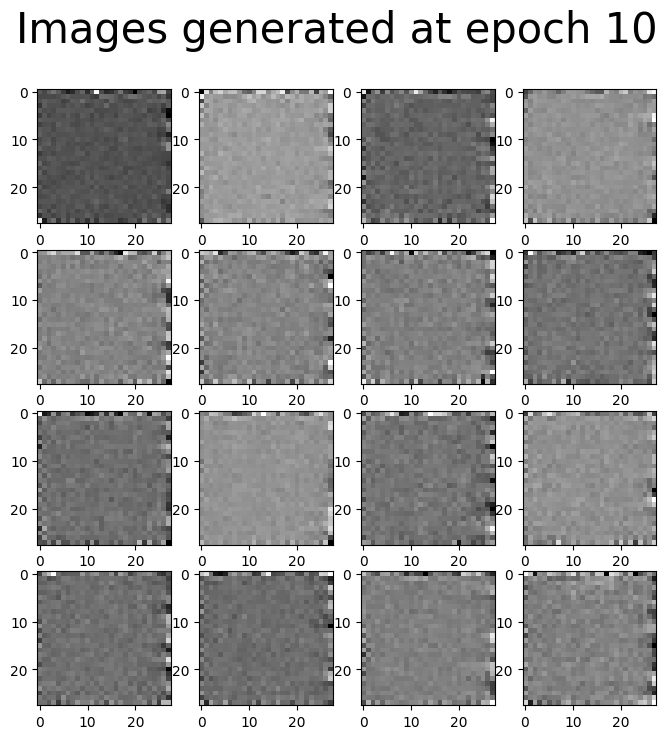

Loss at epoch 10: 4.018


Epoch 10 to 20:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 20: 1.252


Epoch 20 to 30:   0%|          | 0/10 [00:00<?, ?it/s]

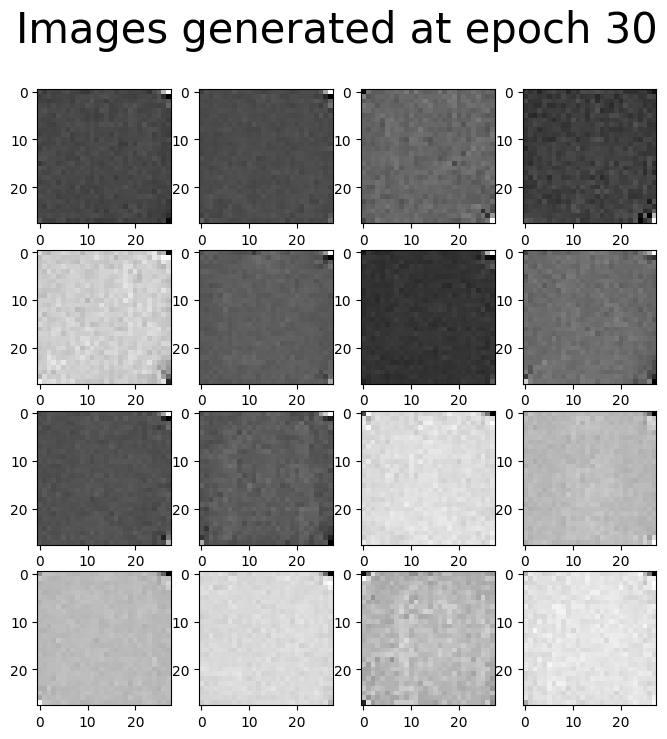

Loss at epoch 30: 0.943


Epoch 30 to 40:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 40: 0.860


Epoch 40 to 50:   0%|          | 0/10 [00:00<?, ?it/s]

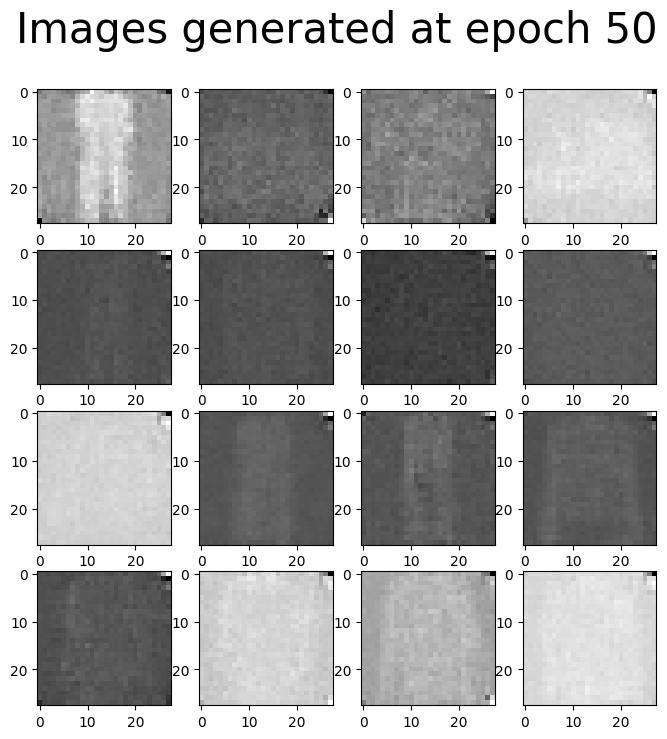

Loss at epoch 50: 0.809


Epoch 50 to 60:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 60: 0.777


Epoch 60 to 70:   0%|          | 0/10 [00:00<?, ?it/s]

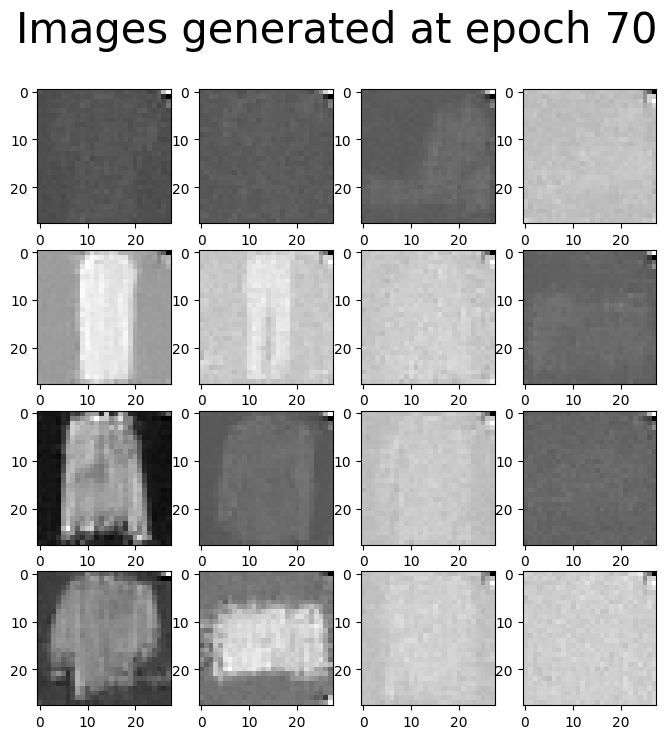

Loss at epoch 70: 0.753


Epoch 70 to 80:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 80: 0.728


Epoch 80 to 90:   0%|          | 0/10 [00:00<?, ?it/s]

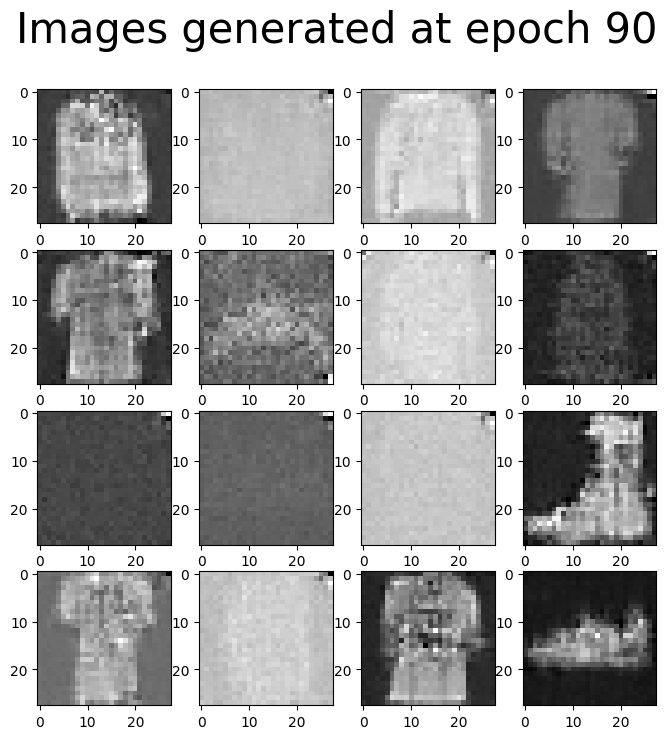

Loss at epoch 90: 0.712


Epoch 90 to 100:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 100: 0.696


Epoch 100 to 110:   0%|          | 0/10 [00:00<?, ?it/s]

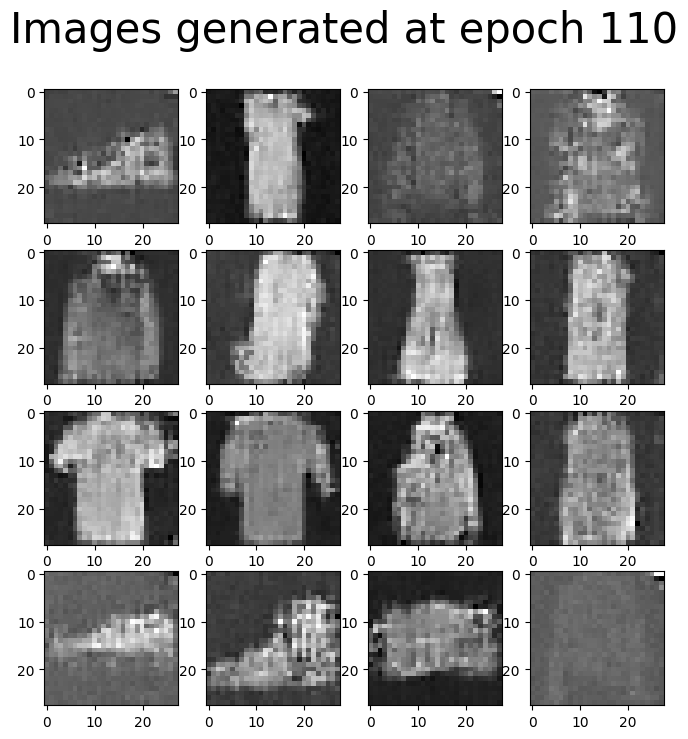

Loss at epoch 110: 0.684


Epoch 110 to 120:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 120: 0.673


Epoch 120 to 130:   0%|          | 0/10 [00:00<?, ?it/s]

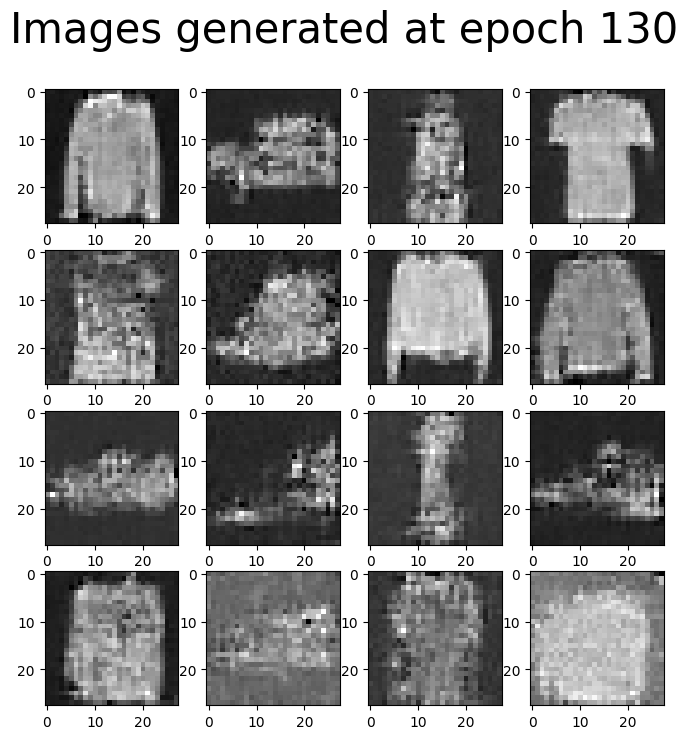

Loss at epoch 130: 0.660


Epoch 130 to 140:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 140: 0.651


Epoch 140 to 150:   0%|          | 0/10 [00:00<?, ?it/s]

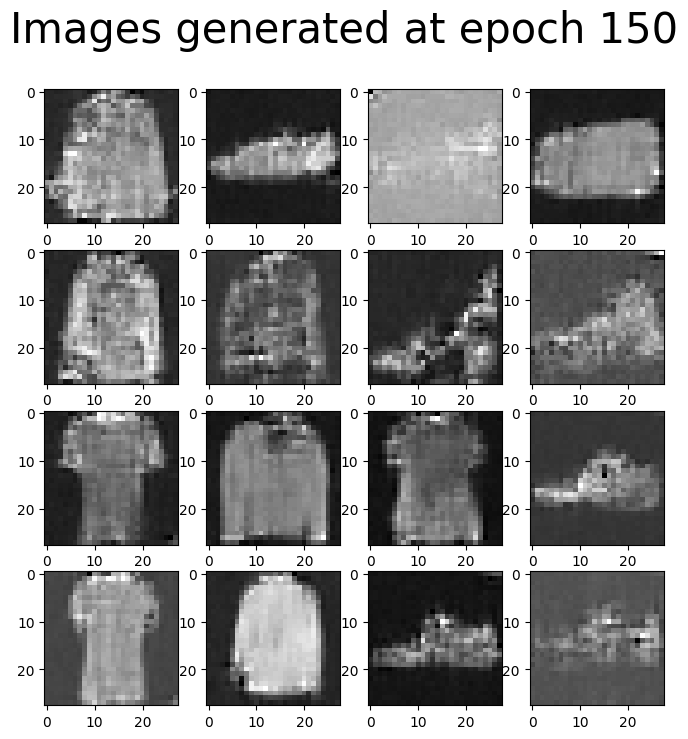

Loss at epoch 150: 0.643


Epoch 150 to 160:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 160: 0.638


Epoch 160 to 170:   0%|          | 0/10 [00:00<?, ?it/s]

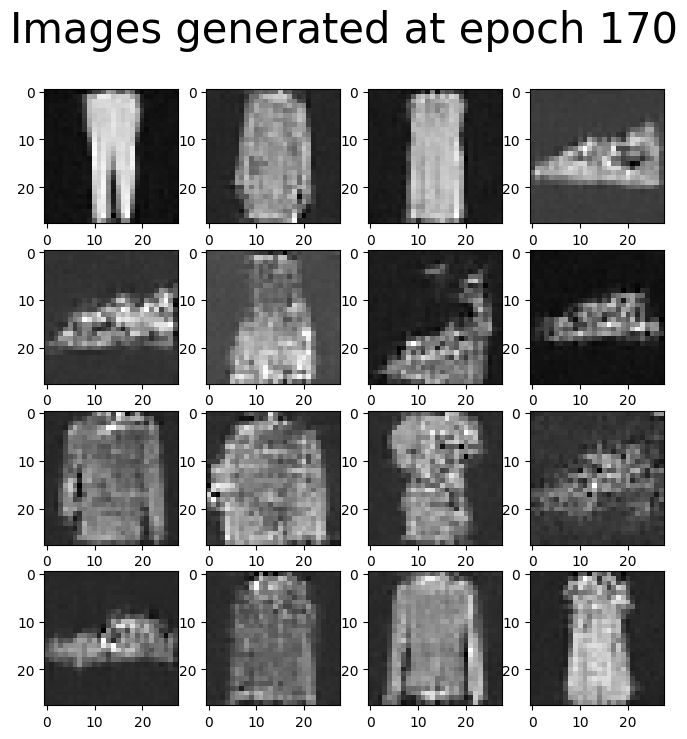

Loss at epoch 170: 0.630


Epoch 170 to 180:   0%|          | 0/10 [00:00<?, ?it/s]

Loss at epoch 180: 0.622


Epoch 180 to 190:   0%|          | 0/10 [00:00<?, ?it/s]

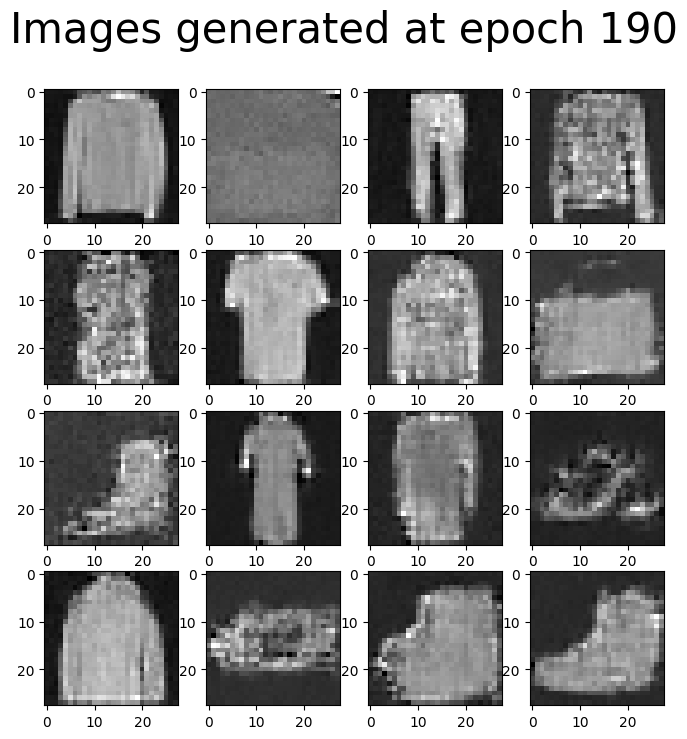

Loss at epoch 190: 0.615


Epoch 190 to 200:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = DDPM(UNet(n_steps), n_steps=n_steps, min_b=min_beta, max_b=max_beta, device=device)
optim=AdamW(ddpm.parameters(),lr=2e-5,eps=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_loop(ddpm, loader,optim, device, n_epochs=1000,  display=True)

In [24]:
device

device(type='cuda')